In [1]:
import numpy as np
import fastmri
import fastmri.data.transforms as T
import matplotlib.pyplot as plt

In [29]:
def make_square_kspace(W: int, w: int, x: int, y: int):
    """
    Returns:
        img  : (1, W, W) float32 spatial image (0–1)
        kspc : (2, W, W) float32 k-space (real, imag)
    """
    if not (0 <= x <= W-w and 0 <= y <= W-w and w >= 3):
        raise ValueError("Square out of bounds or too small (w >= 3).")

    img = np.zeros((W, W), dtype=np.float32)

    # interior fill
    img[y+1:y+w-1, x+1:x+w-1] = 0.5
    # outline

    # 2-px diagonal lines (set back to 0.0)
    for k in range(w-2):
        # main diagonal
        r, c = y+1+k, x+1+k
        img[r-1:r+1, c-1:c+1] = 0.0
        # anti-diagonal
        r2, c2 = y+1+k, x+w-2-k
        img[r2-1:r2+1, c2-1:c2+1] = 0.0
    img[y:y+w, x]   = 1.0
    img[y:y+w, x+w-1] = 1.0
    img[y,   x:x+w] = 1.0
    img[y+w-1, x:x+w] = 1.0

    img = img[np.newaxis, ...]                    # (1, W, W)

    # forward FFT → k-space, split real/imag
    k = np.fft.fftshift(np.fft.fft2(img[0])).astype(np.complex64)
    kspc = np.stack((k.real, k.imag)).astype(np.float32)  # (2, W, W)

    return img, kspc

def make_circle_plus_kspace(W: int, w: int, x: int, y: int):
    """
    Create a (1,W,W) image with a circle and black “+” cross, plus its (2,W,W) k-space.
    """
    if not (0 <= x <= W - w and 0 <= y <= W - w and w >= 3):
        raise ValueError("Circle out of bounds or too small (w ≥ 3).")

    img = np.zeros((W, W), dtype=np.float32)

    # circle geometry
    r  = (w - 1) / 2.0
    cx = x + r
    cy = y + r

    Y, X = np.ogrid[:W, :W]
    dist2   = (Y - cy) ** 2 + (X - cx) ** 2
    inside  = dist2 < (r - 1) ** 2                  # interior (exclude outline)
    outline = np.abs(np.sqrt(dist2) - r) < 0.5      # ≈1-px ring

    img[inside]  = 0.5
    img[outline] = 1.0

    # 2-px “+” cross (horizontal & vertical) inside the circle
    horiz = np.abs(Y - cy) <= 1
    vert  = np.abs(X - cx) <= 1
    cross_mask = inside & (horiz | vert)
    img[cross_mask] = 0.0

    img = img[np.newaxis]                           # (1, W, W)

    k = np.fft.fftshift(np.fft.fft2(img[0])).astype(np.complex64)
    kspc = np.stack((k.real, k.imag)).astype(np.float32)  # (2, W, W)

    return img, kspc

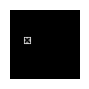

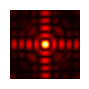

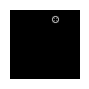

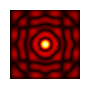

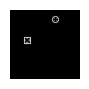

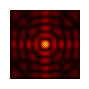

In [33]:
img, kspace = make_square_kspace(100, 10, 20, 40)

# convert kspace to tensor
kspace = T.to_tensor(kspace)
kspace.shape

kspace_abs = fastmri.complex_abs(kspace.permute(1, 2, 0))

img2, kspace2 = make_circle_plus_kspace(100, 10, 60, 10)

kspace2 = T.to_tensor(kspace2)
kspace2_abs = fastmri.complex_abs(kspace2.permute(1, 2, 0))

img3 = img + img2
# k3 = np.fft.fftshift(np.fft.fft2(img3[0])).astype(np.complex64)
# kspace3 = np.stack((k3.real, k3.imag)).astype(np.float32)  # (2, W, W)
# kspace3 = T.to_tensor(kspace3)
kspace3 = kspace + kspace2
kspace3_abs = fastmri.complex_abs(kspace3.permute(1, 2, 0))

figsize = (1.5*12/20, 1.5*12/20)

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(img[0], cmap='gray')
plt.savefig('images/img1.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(kspace_abs, cmap='hot')
plt.savefig('images/kspace1.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(img2[0], cmap='gray')
plt.savefig('images/img2.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(kspace2_abs, cmap='hot')
plt.savefig('images/kspace2.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(img3[0], cmap='gray')
plt.savefig('images/img3.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(kspace3_abs, cmap='hot')
plt.savefig('images/kspace3.png', bbox_inches='tight', dpi=300)
plt.show()
